In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from tqdm.notebook import tqdm
import random
from sklearn.neural_network import MLPClassifier
from collections import Counter

import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
import nltk

In [2]:
# NPY file generated from hatespeech_defer.ipynb
# Underlying dataset from https://github.com/t-davidson/hate-speech-and-offensive-language/

data = np.load('output/labelled_data.npy', allow_pickle=True)[()]
posts = data['posts']
groups = data['groups']
labels = data['labels']

## convert to binary
groups = [int(g) for g in groups]
labels = [1 if int(l) < 2 else 0 for l in labels]

len(posts)

24783

In [3]:
# Loading the pretrained model
def loadGloveModel(File):
    print("Loading Glove Model")
    f = open(File,'r')
    gloveModel = {}
    for line in f:
        splitLines = line.split()
        word = splitLines[0]
        wordEmbedding = np.array([float(value) for value in splitLines[1:]])
        gloveModel[word] = wordEmbedding
    return gloveModel

In [4]:
# replace location below with the location of the glove pretrained model on your system

glove_model = loadGloveModel('/Users/vijaykeswani/Research/multiple_experts/.vector_cache/glove.6B.100d.txt')
vocab = glove_model.keys()
len(vocab)

Loading Glove Model


400000

In [5]:
# ## When using data from the MTurk experiments, uncomment and use the following dataset
# ## Also uncomment all other lines marked with tag <MTurk>

all_results = np.load('../MTurk data/all_results.npy', allow_pickle=True)[()]
ps = list(all_results.keys())
posts = [nltk.word_tokenize(p) for p in ps]
labels = [all_results[p]['label'] for p in ps]
groups = [all_results[p]['dialect'] for p in ps]
decisions = [all_results[p]['decisions'] for p in ps]
NUM_EXPERTS = 176

In [6]:
# Extracting 100-dimensional feature for each post using the pretrained model

postsToFeatures = {}

for i, p in enumerate(tqdm(posts)):
    feat = []
    for w in p:
        if w in vocab:
            feat.append(glove_model[w])
            
    if len(feat) == 0:
        continue
        
    feat = np.mean(feat, axis=0)
    postsToFeatures[i] = feat

len(postsToFeatures)

1470

In [7]:
def flip(p):
    return 1 if random.random() < p else 0

In [8]:
# Train-test partition

def getPartition(frac=0.6):
    N = int(len(posts) * frac)
    indices = list(postsToFeatures.keys())
    
    random.shuffle(indices)
    train = indices[:N]
    test = indices[N:]
    
    return train, test

def getCvPartition(fold):
    indices = list(postsToFeatures.keys())
    N = int(len(indices)/5)
    
    part = []
    part.append(indices[:N])
    part.append(indices[N:N*2])
    part.append(indices[N*2:N*3])
    part.append(indices[N*3:N*4])
    part.append(indices[N*4:])
    
    train = []
    for j in range(5):
        if j == fold:
            continue
        train = train + part[j]
        
    return train, part[fold]

train, test = getPartition()

In [9]:
# Function to get overall accuracy
def getAccuracy(predictions, labels):
    return np.mean(np.array(predictions) == labels)

# Function to get dialect-specific accuracy
def getAccuracyForGroup(predictions, labels, groups, g):
    predictions = [predictions[i]  for i in range(len(predictions)) if groups[i] == g]
    labels = [labels[i]  for i in range(len(labels)) if groups[i] == g]
    
    return np.mean(np.array(predictions) == labels)

In [10]:
# Class for synthetic experts

class UniformExpert:
    def __init__(self, p):
        self.p = p

    def prediction(self, group, label):
        toss = flip(self.p[int(group)])
        return int(label) if toss else 1 - int(label)
    
    def __str__(self):
        return "Expert accuracies:" + str(round(self.p[0],2)) + ", "  + str(round(self.p[0],2))

In [11]:
## Expert design - Non-AAE will be correctly labelled with probability p ~ Unif(0.5,1) 
## and AAE will be correctly labelled with probability q ~ Unif(0.5, p) 
## Swtched if toggle=1

def getUniformExpert(num, minProb=0.5, toggle=0):
    experts = []
    for i in range(num):
        p = np.random.uniform(minProb, 1)
        q = np.random.uniform(minProb, p)
        if toggle:
            p, q = q, p
        
        experts.append(UniformExpert((p,q)))
    return experts


### Joint learning of classifier and deferrer

In [12]:
input_size = 100

# Model for deferrer
# Note that the output of the deferrer can be interpreted as the weight assigned to a particular expert
def getModel():
    model = nn.Sequential(
        nn.Linear(input_size, 128),
        nn.ReLU(),
        nn.Linear(128, 32),
        nn.ReLU(),
        nn.Linear(32, NUM_EXPERTS+1),
        nn.Sigmoid()
    )

    return model

# Model for classifier
def getClassifier():
    model = nn.Sequential(
        nn.Linear(input_size, 128),
        nn.ReLU(),
        nn.Linear(128, 32),
        nn.ReLU(),
        nn.Linear(32, 1),
        nn.Sigmoid()
    )

    return model
    

In [13]:
# Fucntion to get costs associated with experts
# Currently assigning unit costs with all experts and zeor cost with classifier
def getExpertCosts(experts):
    costs = []
    for e in experts:
#         c = max(e.p[0], e.p[1])
        c = 1
        costs.append(c)
    costs.append(0)    
    return torch.Tensor(costs)

# Function to get synthetic expert predictions for any given input
def getExpertPredictions(experts, groups, labels, i, dropout=0):
    expertPreds = [experts[j].prediction(int(groups[i]), int(labels[i])) if flip(1-dropout) else 0 for j in range(NUM_EXPERTS)]
    return expertPreds

# Function to get synthetic expert predictions for any given input
def getExpertPredictionsMTurk(decisions, i):
    expertPreds = [decisions[i][j] if j in decisions[i].keys() else 0 for j in range(NUM_EXPERTS)]
    return expertPreds

In [43]:
# Function to get final prediciton using by calculating probability of class label 1
# Note that this function takes the weights of all experts into account, and deferring to all experts might be
# infeasible in real-world application
def getFinalPrediction(output, expertPreds):
    output = output.tolist()
    output2 = np.dot(output, expertPreds)
    output2 = np.exp(output2)/(np.exp(1 - output2) + np.exp(output2))
    return output2 > 0.5

# Function to get final prediciton using by sampling a committee of experts
# This function uses the weight distribution to sample a small committee of experts,
# and the majority decision of the committee is the final output
# def getFinalPredictionSparse(output, expertPreds, k=5):
#     output = np.array(output.tolist())
#     p = output/sum(output)
#     indices = np.random.choice(list(range(len(output))), p=p, size=k)
#     preds = [expertPreds[i] for i in indices]
#     result = sum(output) * np.mean(preds)
    
#     return result > 0.5

def getFinalPredictionSparse(output, expertPreds, k=5):
    output = np.array(output.tolist())
    p = output/sum(output)
    indices = np.random.choice(list(range(len(output))), p=p, size=k)
    preds = [expertPreds[i] for i in indices]
    output2 = sum(output) * np.mean(preds)
    
    output2 = np.exp(output2)/(np.exp(1 - output2) + np.exp(output2))
    return output2 > 0.5

# This function is similar to the above one, the only difference is that
# the classifier is always part of the chosen committee in this case
def getFinalPredictionSparse2(output, expertPreds, k=5):
    output = np.array(output.tolist())[:-1]
    p = output/sum(output)
    indices = np.random.choice(list(range(len(output))), p=p, size=k-1)
    preds = [expertPreds[i] for i in indices]
    preds.append(expertPreds[-1])
    result = sum(output) * np.mean(preds)
    
    return result > 0.5


#### Baselines

In [26]:
# Function to simulate the baseline where the committee is chosen randomly
def getRandomPredictions(expertPreds, clf_pred, k=5):
    indices = list(range(NUM_EXPERTS))
    random.shuffle(indices)
    committee = [clf_pred] + [expertPreds[i] for i in indices[:k]]
    return np.mean(committee) > 0.5

# Function to simulate the baseline where the committee is chosen randomly
# amongst the experts that have a higher accuracy for the given dialect.
def getRandomFairPredictions(experts, group, expertPreds, clf_pred, k=5):
    if group:
        indices = [i for i in range(NUM_EXPERTS) if experts[i].p[0] < experts[i].p[1]]
    else:
        indices = [i for i in range(NUM_EXPERTS) if experts[i].p[0] > experts[i].p[1]]
    random.shuffle(indices)
    committee = [clf_pred] + [expertPreds[i] for i in indices[:k]]
    return np.mean(committee) > 0.5

## Use this section for completed codes

In [27]:
# NUM_EXPERTS = 20 # comment/change when using <MTurk>
minProb = 0.6  # minimum expert accuracy
experts = getUniformExpert(NUM_EXPERTS, minProb)  
expert_costs = getExpertCosts(experts)

In [28]:
T = 100   # number of iterations of optimization
batch_size = 200   # batch size per iteration
lr1 = 0.3   # learning rate for joint learning model
lr2 = 0.3   # learning rate for fair joint learning model
c_exp = 0.5  
# lambda_cost = 0.17
lambda_cost = 0
dropout = 0.2  # probability with which an expert decision is randomly dropped - reduces overdependence


# Function to simultaneously learn a classifier and deferrer
# the loss function simply calculates the probability of class label being 1
# and then applies the log-loss function over this probability
def getTrainedModel(train, experts):
    model = getModel()
    classifier = getClassifier()
    optimizer = optim.SGD(list(model.parameters()) + list(classifier.parameters()), lr=lr1)

    for t in range(1, T+1):
        
        random.shuffle(train)
        trainFeatures = [postsToFeatures[i] for i in train[:batch_size]]
        trainLabels = [int(labels[i]) for i in train[:batch_size]]
        trainGroups = [int(groups[i]) for i in train[:batch_size]]
#         trainDecisions = [getExpertPredictions(experts, groups, labels, i, dropout)  for i in train[:batch_size]]
        
#         comment above and uncomment below when using <MTurk>
        trainDecisions = [getExpertPredictionsMTurk(decisions, i) for i in train[:batch_size]]
        
        outputs, inputs, expPreds = [], [], []
        optimizer.zero_grad()

        loss_clf, loss_all, cost = 0, 0, 0
        for feat, label, group, decs in zip(trainFeatures, trainLabels, trainGroups, trainDecisions):
            # get expert predictions
            expertPreds = list(decs)

            x = torch.Tensor(feat)
            # get classifier predictions
            clf_pred = classifier(x)
            
            expertPreds.append(clf_pred)
            expertPreds = torch.Tensor(expertPreds)
            expPreds.append(expertPreds)

            # get deferrer weights
            output = model(x)
            
            # calculate cost of output            
            cost += torch.dot(output, expert_costs)

            # calculate probability of class label being 1            
            output2 = torch.dot(output, expertPreds)
            output2 = torch.exp(output2)/(torch.exp(1 - output2) + torch.exp(output2))

            # log-loss of above probability
            if label:
                loss_all -= torch.log(output2)
                loss_clf -= torch.log(clf_pred)            
            else:
                loss_all -= torch.log(1-output2)
                loss_clf -= torch.log(1-clf_pred)

        # combine losses and costs                            
        loss = (1 - t**-c_exp) * loss_all/batch_size + loss_clf/batch_size + lambda_cost * cost/batch_size
  
        loss.backward()
        optimizer.step()

    return classifier, model

# Function to simultaneously learn a classifier and deferrer in an unbiased manner
# The primary difference from above model is that here the loss values of the two dialects
# are calculated separately, so as to finally obtain a balanced error rate across dialects.
def getTrainedFairModel(train, experts):
    model = getModel()
    classifier = getClassifier()
    optimizer = optim.SGD(list(model.parameters()) + list(classifier.parameters()), lr=lr1)
    
    for t in range(1,T+1):
        random.shuffle(train)
        trainFeatures = [postsToFeatures[i] for i in train[:batch_size]]
        trainLabels = [int(labels[i]) for i in train[:batch_size]]
        trainGroups = [int(groups[i]) for i in train[:batch_size]]
#         trainDecisions = [getExpertPredictions(experts, groups, labels, i, dropout)  for i in train[:batch_size]]

#         comment above and uncomment below when using <MTurk>
        trainDecisions = [getExpertPredictionsMTurk(decisions, i) for i in train[:batch_size]]

        outputs, inputs, expPreds = [], [], []
        optimizer.zero_grad()

        loss_aae, loss_std, loss_clf, cost, c1, c2 = 0, 0, 0, 0, 0, 0
        for feat, label, group, decs in zip(trainFeatures, trainLabels, trainGroups, trainDecisions):
            expertPreds = list(decs)

            x = torch.Tensor(feat)
            clf_pred = classifier(x)
            expertPreds.append(clf_pred)
            expertPreds = torch.Tensor(expertPreds)
            expPreds.append(expertPreds)

            output = model(x)
            cost += torch.dot(output, expert_costs)

            output2 = torch.dot(output, expertPreds)
            output2 = torch.exp(output2)/( torch.exp(1 - output2) + torch.exp(output2))

            
            if label:
                loss_clf -= torch.log(clf_pred)            
            else:
                loss_clf -= torch.log(1-clf_pred)
            
            if group == 1:
                if label:
                    loss_aae -= torch.log(output2)
                else:
                    loss_aae -= torch.log(1-output2)
                c1 += 1
            else:
                if label:
                    loss_std -= torch.log(output2)
                else:
                    loss_std -= torch.log(1-output2)
                c2 += 1

                
        loss = loss_aae/c1 + loss_std/c2
        loss = (1 - t**-c_exp) * loss + loss_clf/batch_size + lambda_cost * cost/batch_size

        loss.backward()
        optimizer.step()

    return classifier, model

minimax_T = 5
def getTrainedMinimaxModel(train, experts, lambda_cost=0):    
    z1 = sum([int(groups[i]) for i in train])
    group_weights = [1 - z1/len(train), z1/len(train)]
    models, classifiers = [], []
    for mt in range(1, minimax_T+1):
    #     T = 200
        losses, costs = [], []
    #     batch_size = 50

        model = getModel()
        classifier = getClassifier()
        optimizer = optim.SGD(list(model.parameters()) + list(classifier.parameters()), lr=lr1)


        for t in range(1, T+1):
            running_loss = 0

            random.shuffle(train)
            trainFeatures = [postsToFeatures[i] for i in train[:batch_size]]
            trainLabels = [int(labels[i]) for i in train[:batch_size]]
            trainGroups = [int(groups[i]) for i in train[:batch_size]]
            trainPosts = [posts[i] for i in train[:batch_size]]
#             trainDecisions = [getExpertPredictions(experts, groups, labels, i, dropout)  for i in train[:batch_size]]
            
            trainDecisions = [getExpertPredictionsMTurk(decisions, i) for i in train[:batch_size]]

            outputs, inputs, expPreds = [], [], []
            optimizer.zero_grad()

            loss_clf_aae, loss_all_aae, loss_clf_std, loss_all_std, cost = 0, 0, 0, 0, 0
            for feat, label, group, post, decs in zip(trainFeatures, trainLabels, trainGroups, trainPosts, trainDecisions):
                expertPreds = list(decs)

                x = torch.Tensor(feat)
                clf_pred = classifier(x)
                expertPreds.append(clf_pred)
                expertPreds = torch.Tensor(expertPreds)
                expPreds.append(expertPreds)

                output = model(x)
                cost += torch.dot(output, expert_costs)

                output2 = torch.dot(output, expertPreds)
                output2 = torch.exp(output2)/( torch.exp(1 - output2) + torch.exp(output2))

                if label:
                    if group:
                        loss_all_aae -= torch.log(output2)
                        loss_clf_aae -= torch.log(clf_pred)
                    else:
                        loss_all_std -= torch.log(output2)
                        loss_clf_std -= torch.log(clf_pred)
                else:
                    if group:
                        loss_all_aae -= torch.log(1-output2)
                        loss_clf_aae -= torch.log(1-clf_pred)
                    else:
                        loss_all_std -= torch.log(1-output2)
                        loss_clf_std -= torch.log(1-clf_pred)

            z1 = sum(trainGroups)
            z0 = len(trainGroups) - z1
            loss_aae = (1 - t**-c_exp) * loss_all_aae/z1 + loss_clf_aae/z1 
            loss_std = (1 - t**-c_exp) * loss_all_std/z0 + loss_clf_std/z0

            loss = group_weights[1] * loss_aae + group_weights[0] * loss_std + lambda_cost * cost/batch_size
            loss.backward()
            optimizer.step()

            losses.append(loss.item())
            costs.append(cost.item())

        models.append(model)
        classifiers.append(classifier)
        group_weights[1] = group_weights[1] * np.exp(1/np.sqrt(mt) * loss_aae.item())
        group_weights[0] = group_weights[0] * np.exp(1/np.sqrt(mt) * loss_std.item())
    return classifiers, models


In [29]:
frac = 0.8  # train-test partition fraction
reps = 5   # number of repetitions

In [47]:
clf_accs, joint_accs, joint_fair_accs, joint_accs_sp, joint_fair_accs_sp, random_accs, random_fair_accs = [], [], [], [], [], [], []
joint_accs_mx, joint_mx_accs_sp = [], []
# Each repetition involves sampling new synthetic experts,
# getting new train-test partitions,
# training and recording the performance of classifier-deferrer models,
# obtaining baseline performances

for r in tqdm(range(reps)):
#     train, test = getPartition() 
    train, test = getCvPartition(r)
    trainFeatures = [postsToFeatures[i] for i in train]
    trainLabels = [int(labels[i]) for i in train]

    testFeatures = [postsToFeatures[i] for i in test]
    testLabels = [int(labels[i]) for i in test]
    testGroups = [int(groups[i]) for i in test]
#     testDecisions = [getExpertPredictions(experts, groups, labels, i, dropout)  for i in test]

#   comment above and uncomment below when using <MTurk>
    testDecisions = [getExpertPredictionsMTurk(decisions, i) for i in test]

    # baseline - classifier
    clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1, max_iter=10000)
    clf.fit(trainFeatures, trainLabels)

    clf_pred = clf.predict(testFeatures)
    clf_acc = (getAccuracyForGroup(clf_pred, testLabels, testGroups, 0), 
           getAccuracyForGroup(clf_pred, testLabels, testGroups, 1), 
           getAccuracy(clf_pred, testLabels))
    clf_accs.append(clf_acc)
    
    trainGroups = [int(groups[j]) for j in train]
    experts = getUniformExpert(15, minProb)      
    experts = experts + getUniformExpert(5, minProb, toggle=1)      
    random.shuffle(experts)

#     joint learning - simple
    classifier, model = getTrainedModel(train, experts)
    
#     joint learning - fairness update - balanced error rate
    classifier2, model2 = getTrainedFairModel(train, experts)
    
#     classifiers3, models3 = getTrainedMinimaxModel(train, experts)

    random_pred, random_fair_pred, joint_pred, joint_pred_fair = [], [], [], []
    joint_pred_mx, joint_pred_mx_sp = [], []
    joint_pred_sp, joint_pred_fair_sp = {k:[] for k in range(5, 170)}, {k:[] for k in range(5, 170)}
    
    for feat, label, group, decs in zip(testFeatures, testLabels, testGroups, testDecisions):
        x = torch.Tensor(feat)
        output = model(x)
        output2 = model2(x)

        expertPreds = list(decs)
        expertPreds.append(classifier(torch.Tensor(x)).item() > 0.5)
        expertPreds = torch.Tensor(expertPreds)
        
        joint_pred.append(getFinalPrediction(output, expertPreds))    
        
        for k in range(5, 170):
            joint_pred_sp[k].append(getFinalPredictionSparse(output, expertPreds, k=k))    

        expertPreds = list(decs)
        expertPreds.append(classifier2(torch.Tensor(x)).item() > 0.5)
        expertPreds = torch.Tensor(expertPreds)
        
        joint_pred_fair.append(getFinalPrediction(output2, expertPreds))    
#         joint_pred_fair_sp.append(getFinalPredictionSparse(output2, expertPreds))    
        for k in range(5, 170):
            joint_pred_fair_sp[k].append(getFinalPredictionSparse(output2, expertPreds, k=k))    

#         preds1, preds2 = [], []
#         for j in range(minimax_T):
#             model3, classifier3 = models3[j], classifiers3[j]
#             output3 = model3(x)

#             expertPreds = list(decs)
#             expertPreds.append(classifier3(torch.Tensor(x)).item() > 0.5)
#             expertPreds = torch.Tensor(expertPreds)

#             preds1.append(getFinalPrediction(output3, expertPreds))
#             preds2.append(getFinalPredictionSparse(output3, expertPreds))
#         joint_pred_mx.append(np.mean(preds1) > 0.5)    
#         joint_pred_mx_sp.append(np.mean(preds2) > 0.5)    
        
#        Comment random committee selection baselines when using <MTurk>
#         random_pred.append(getRandomPredictions(expertPreds, clf.predict([feat])[0]))
#         random_fair_pred.append(getRandomFairPredictions(experts, group, expertPreds, clf.predict([feat])[0]))
        
    acc = (getAccuracyForGroup(joint_pred, testLabels, testGroups, 0), 
           getAccuracyForGroup(joint_pred, testLabels, testGroups, 1), 
           getAccuracy(joint_pred, testLabels))
    print ("joint", acc)
    joint_accs.append(acc)

    acc = (getAccuracyForGroup(joint_pred_fair, testLabels, testGroups, 0), 
           getAccuracyForGroup(joint_pred_fair, testLabels, testGroups, 1), 
           getAccuracy(joint_pred_fair, testLabels))
    print ("joint fair", acc)
    joint_fair_accs.append(acc)
    
    accs = []
    for k in range(5, 170):
        acc = (getAccuracyForGroup(joint_pred_sp[k], testLabels, testGroups, 0), 
               getAccuracyForGroup(joint_pred_sp[k], testLabels, testGroups, 1), 
               getAccuracy(joint_pred_sp[k], testLabels))
        accs.append(acc)
#     print ("joint sparse", acc)
    joint_accs_sp.append(accs)
    
    accs = []
    for k in range(5, 170):
        acc = (getAccuracyForGroup(joint_pred_fair_sp[k], testLabels, testGroups, 0), 
               getAccuracyForGroup(joint_pred_fair_sp[k], testLabels, testGroups, 1), 
               getAccuracy(joint_pred_fair_sp[k], testLabels))
        accs.append(acc)
#     print ("joint fair sparse", acc)
    joint_fair_accs_sp.append(accs)

#     acc = (getAccuracyForGroup(joint_pred_mx, testLabels, testGroups, 0), 
#            getAccuracyForGroup(joint_pred_mx, testLabels, testGroups, 1), 
#            getAccuracy(joint_pred_mx, testLabels))
#     print ("minimax", acc)
#     joint_accs_mx.append(acc)

#     acc = (getAccuracyForGroup(joint_pred_mx_sp, testLabels, testGroups, 0), 
#            getAccuracyForGroup(joint_pred_mx_sp, testLabels, testGroups, 1), 
#            getAccuracy(joint_pred_mx_sp, testLabels))
#     print ("minimax sparse", acc)
#     joint_mx_accs_sp.append(acc)

#     # Comment the rest of code here when using <MTurk>, since these baselines do not make sense in that case
#     acc = (getAccuracyForGroup(random_pred, testLabels, testGroups, 0), 
#            getAccuracyForGroup(random_pred, testLabels, testGroups, 1), 
#            getAccuracy(random_pred, testLabels))
#     random_accs.append(acc)

#     acc = (getAccuracyForGroup(random_fair_pred, testLabels, testGroups, 0), 
#            getAccuracyForGroup(random_fair_pred, testLabels, testGroups, 1), 
#            getAccuracy(random_fair_pred, testLabels))
#     random_fair_accs.append(acc)



joint (0.8322147651006712, 0.7931034482758621, 0.8129251700680272)
joint fair (0.8389261744966443, 0.7793103448275862, 0.8095238095238095)
joint (0.8356164383561644, 0.7905405405405406, 0.8129251700680272)
joint fair (0.821917808219178, 0.7635135135135135, 0.7925170068027211)
joint (0.8873239436619719, 0.8026315789473685, 0.8435374149659864)
joint fair (0.8802816901408451, 0.8026315789473685, 0.8401360544217688)
joint (0.9038461538461539, 0.855072463768116, 0.8809523809523809)
joint fair (0.8910256410256411, 0.855072463768116, 0.8741496598639455)
joint (0.9, 0.8611111111111112, 0.8809523809523809)
joint fair (0.8466666666666667, 0.8472222222222222, 0.8469387755102041)



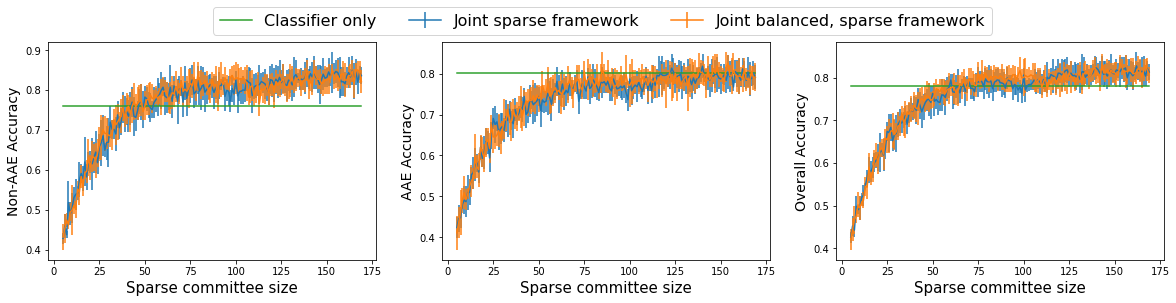

In [99]:
# std_acc = np.mean([np.array(joint_accs_sp[i])[:,0] for i in range(5)], axis=0)
# std_acc_sd = np.mean([np.array(joint_accs_sp[i])[:,0] for i in range(5)], axis=0)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))
ylabels = ["Non-AAE Accuracy", "AAE Accuracy", "Overall Accuracy"]

def getPlot(accs, ax, xs, j, label=""):
    joint_mean = np.mean([np.array(accs[i])[:,j] for i in range(5)], axis=0)
    joint_std = np.std([np.array(accs[i])[:,j] for i in range(5)], axis=0)
    ax.errorbar(np.array(xs), joint_mean, yerr=joint_std, label=label)
    

for i in range(3):
    xs = list(range(5, 170))
    
    getPlot(joint_accs_sp, ax[i], xs, i, "Joint sparse framework")
    getPlot(joint_fair_accs_sp, ax[i], xs, i, "Joint balanced, sparse framework")
    ax[i].set_ylabel(ylabels[i], fontsize=14)
    ax[i].set_xlabel("Sparse committee size", fontsize=15)
    clf_mean = np.mean(np.array([clf_accs[j] for j in range(5)])[:,i])
#     clf_std = np.std([np.array(accs[i])[:,i] for i in range(5)], axis=0)
    ax[i].plot(xs, [clf_mean for _ in xs], label="Classifier only", markersize=20)
    
ax[0].legend(bbox_to_anchor=(2.9, 1.2), ncol=4, fontsize=16)


In [94]:
clf = np.mean(np.array([clf_accs[j] for j in range(5)])[:,2])
list(zip(xs, [clf- np.mean([np.array(joint_accs_sp[i])[:,2] for i in range(5)], axis=0) < 0.01][0]))

[(5, False),
 (6, False),
 (7, False),
 (8, False),
 (9, False),
 (10, False),
 (11, False),
 (12, False),
 (13, False),
 (14, False),
 (15, False),
 (16, False),
 (17, False),
 (18, False),
 (19, False),
 (20, False),
 (21, False),
 (22, False),
 (23, False),
 (24, False),
 (25, False),
 (26, False),
 (27, False),
 (28, False),
 (29, False),
 (30, False),
 (31, False),
 (32, False),
 (33, False),
 (34, False),
 (35, False),
 (36, False),
 (37, False),
 (38, False),
 (39, False),
 (40, False),
 (41, False),
 (42, False),
 (43, False),
 (44, False),
 (45, False),
 (46, False),
 (47, False),
 (48, False),
 (49, False),
 (50, False),
 (51, False),
 (52, False),
 (53, False),
 (54, False),
 (55, False),
 (56, False),
 (57, False),
 (58, True),
 (59, True),
 (60, True),
 (61, False),
 (62, False),
 (63, True),
 (64, True),
 (65, False),
 (66, True),
 (67, True),
 (68, False),
 (69, True),
 (70, True),
 (71, True),
 (72, True),
 (73, False),
 (74, True),
 (75, True),
 (76, True),
 (77, True)

In [41]:
def getFinalPrediction(output, expertPreds):
    output = output.tolist()
    output2 = np.dot(output, expertPreds)
    output2 = np.exp(output2)/(np.exp(1 - output2) + np.exp(output2))
    return output2 > 0.5

def getFinalPredictionSparse(output, expertPreds, k=5):
    output = np.array(output.tolist())
    p = output/sum(output)
    indices = np.random.choice(list(range(len(output))), p=p, size=k)
    preds = [expertPreds[i] for i in indices]
    output2 = sum(output) * np.mean(preds)
    
    output2 = np.exp(output2)/(np.exp(1 - output2) + np.exp(output2))
    return output2 > 0.5

random_pred, random_fair_pred, joint_pred, joint_pred_fair, joint_pred_sp, joint_pred_fair_sp = [], [], [], [], [], []
for feat, label, group, decs in zip(testFeatures, testLabels, testGroups, testDecisions):
    x = torch.Tensor(feat)
    output = model(x)

    expertPreds = list(decs)
    expertPreds.append(classifier(torch.Tensor(x)).item() > 0.5)
    expertPreds = torch.Tensor(expertPreds)

    joint_pred.append(getFinalPrediction(output, expertPreds))    
    joint_pred_sp.append(getFinalPredictionSparse(output, expertPreds, k=50))    


acc = (getAccuracyForGroup(joint_pred, testLabels, testGroups, 0), 
       getAccuracyForGroup(joint_pred, testLabels, testGroups, 1), 
       getAccuracy(joint_pred, testLabels))
print ("joint", acc)
joint_accs.append(acc)


acc = (getAccuracyForGroup(joint_pred_sp, testLabels, testGroups, 0), 
       getAccuracyForGroup(joint_pred_sp, testLabels, testGroups, 1), 
       getAccuracy(joint_pred_sp, testLabels))
print ("joint sparse", acc)
joint_accs_sp.append(acc)


joint (0.8561643835616438, 0.8445945945945946, 0.8503401360544217)
joint sparse (0.7328767123287672, 0.8243243243243243, 0.7789115646258503)


In [82]:
joint_fair_acc_sp_0 = [a[0] for a in joint_accs_mx]
joint_fair_acc_sp_1 = [a[1] for a in joint_accs_mx]
joint_fair_acc_sp_2 = [a[2] for a in joint_accs_mx]

print ("Joint fair and sparse:", "&", round(np.mean(joint_fair_acc_sp_2),2), "(",  round(np.std(joint_fair_acc_sp_2),2), ") &",
       round(np.mean(joint_fair_acc_sp_0),2), "(",  round(np.std(joint_fair_acc_sp_0),2), ") &", 
       round(np.mean(joint_fair_acc_sp_1),2), "(",  round(np.std(joint_fair_acc_sp_1),2), ") \\\\")


Joint fair and sparse: & 0.85 ( 0.02 ) & 0.87 ( 0.02 ) & 0.83 ( 0.02 ) \\


#### Tabulated results

In [81]:
clf_acc_0 = [a[0] for a in clf_accs]
clf_acc_1 = [a[1] for a in clf_accs]
clf_acc_2 = [a[2] for a in clf_accs]

joint_acc_0 = [a[0] for a in joint_accs]
joint_acc_1 = [a[1] for a in joint_accs]
joint_acc_2 = [a[2] for a in joint_accs]

joint_fair_acc_0 = [a[0] for a in joint_fair_accs]
joint_fair_acc_1 = [a[1] for a in joint_fair_accs]
joint_fair_acc_2 = [a[2] for a in joint_fair_accs]

joint_acc_sp_0 = [a[0] for a in joint_accs_sp]
joint_acc_sp_1 = [a[1] for a in joint_accs_sp]
joint_acc_sp_2 = [a[2] for a in joint_accs_sp]

joint_fair_acc_sp_0 = [a[0] for a in joint_fair_accs_sp]
joint_fair_acc_sp_1 = [a[1] for a in joint_fair_accs_sp]
joint_fair_acc_sp_2 = [a[2] for a in joint_fair_accs_sp]

# Comment random committee selection baselines when using <MTurk>
random_acc_0 = [a[0] for a in random_accs]
random_acc_1 = [a[1] for a in random_accs]
random_acc_2 = [a[2] for a in random_accs]

random_fair_acc_0 = [a[0] for a in random_fair_accs]
random_fair_acc_1 = [a[1] for a in random_fair_accs]
random_fair_acc_2 = [a[2] for a in random_fair_accs]

print ("Classifier:", "&", round(np.mean(clf_acc_2),2), "(",  round(np.std(clf_acc_2),2), ") &",
       round(np.mean(clf_acc_0),2), "(",  round(np.std(clf_acc_0),2), ") &", 
       round(np.mean(clf_acc_1),2), "(",  round(np.std(clf_acc_1),2), ") \\\\")

print ("Random:", "&", round(np.mean(random_acc_2),2), "(",  round(np.std(random_acc_2),2), ") &",
       round(np.mean(random_acc_0),2), "(",  round(np.std(random_acc_0),2), ") &", 
       round(np.mean(random_acc_1),2), "(",  round(np.std(random_acc_1),2), ") \\\\")

print ("Random fair:", "&", round(np.mean(random_fair_acc_2),2), "(",  round(np.std(random_fair_acc_2),2), ") &",
       round(np.mean(random_fair_acc_0),2), "(",  round(np.std(random_fair_acc_0),2), ") &", 
       round(np.mean(random_fair_acc_1),2), "(",  round(np.std(random_fair_acc_1),2), ") \\\\")

print ("Joint:", "&", round(np.mean(joint_acc_2),2), "(",  round(np.std(joint_acc_2),2), ") &",
       round(np.mean(joint_acc_0),2), "(",  round(np.std(joint_acc_0),2), ") &", 
       round(np.mean(joint_acc_1),2), "(",  round(np.std(joint_acc_1),2), ") \\\\")

print ("Joint fair:", "&", round(np.mean(joint_fair_acc_2),2), "(",  round(np.std(joint_fair_acc_2),2), ") &",
       round(np.mean(joint_fair_acc_0),2), "(",  round(np.std(joint_fair_acc_0),2), ") &", 
       round(np.mean(joint_fair_acc_1),2), "(",  round(np.std(joint_fair_acc_1),2), ") \\\\")

print ("Joint sparse:", "&", round(np.mean(joint_acc_sp_2),2), "(",  round(np.std(joint_acc_sp_2),2), ") &",
       round(np.mean(joint_acc_sp_0),2), "(",  round(np.std(joint_acc_sp_0),2), ") &", 
       round(np.mean(joint_acc_sp_1),2), "(",  round(np.std(joint_acc_sp_1),2), ") \\\\")

print ("Joint fair and sparse:", "&", round(np.mean(joint_fair_acc_sp_2),2), "(",  round(np.std(joint_fair_acc_sp_2),2), ") &",
       round(np.mean(joint_fair_acc_sp_0),2), "(",  round(np.std(joint_fair_acc_sp_0),2), ") &", 
       round(np.mean(joint_fair_acc_sp_1),2), "(",  round(np.std(joint_fair_acc_sp_1),2), ") \\\\")


Classifier: & 0.78 ( 0.02 ) & 0.76 ( 0.05 ) & 0.8 ( 0.04 ) \\
Random: & nan ( nan ) & nan ( nan ) & nan ( nan ) \\
Random fair: & nan ( nan ) & nan ( nan ) & nan ( nan ) \\
Joint: & nan ( nan ) & nan ( nan ) & nan ( nan ) \\
Joint fair: & nan ( nan ) & nan ( nan ) & nan ( nan ) \\
Joint sparse: & nan ( nan ) & nan ( nan ) & nan ( nan ) \\
Joint fair and sparse: & nan ( nan ) & nan ( nan ) & nan ( nan ) \\


/Users/vijaykeswani/Library/Python/3.8/lib/python/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/vijaykeswani/Library/Python/3.8/lib/python/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/vijaykeswani/Library/Python/3.8/lib/python/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/vijaykeswani/Library/Python/3.8/lib/python/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/Users/vijaykeswani/Library/Python/3.8/lib/python/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


#### Plotted results, i.e, means and stadndard deviations of overall and group specific accuracies of different methods

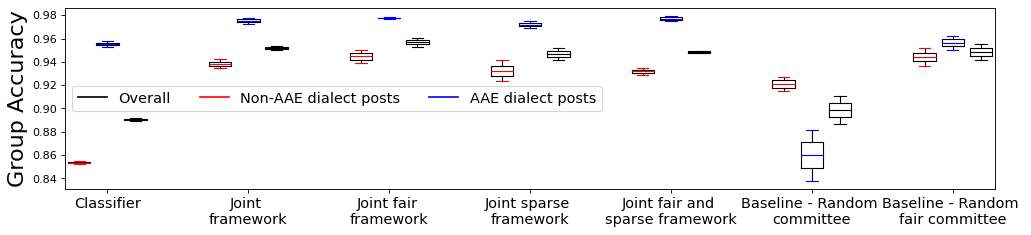

In [113]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(15, 3), dpi=80, facecolor='w', edgecolor='k')


plt.boxplot([clf_acc_0], positions=[0], widths=0.8, capprops=dict(color="red"), medianprops=dict(color="red"))
plt.boxplot([clf_acc_1], positions=[1], widths=0.8, capprops=dict(color="blue"), medianprops=dict(color="blue"))
plt.boxplot([clf_acc_2], positions=[2], widths=0.8, capprops=dict(color="black"), medianprops=dict(color="black"))

plt.boxplot([joint_acc_0], positions=[5], widths=0.8, capprops=dict(color="red"), medianprops=dict(color="red"))
plt.boxplot([joint_acc_1], positions=[6], widths=0.8, capprops=dict(color="blue"), medianprops=dict(color="blue"))
plt.boxplot([joint_acc_2], positions=[7], widths=0.8, capprops=dict(color="black"), medianprops=dict(color="black"))

plt.boxplot([joint_fair_acc_0], positions=[10], widths=0.8, capprops=dict(color="red"), medianprops=dict(color="red"))
plt.boxplot([joint_fair_acc_1], positions=[11], widths=0.8, capprops=dict(color="blue"), medianprops=dict(color="blue"))
plt.boxplot([joint_fair_acc_2], positions=[12], widths=0.8, capprops=dict(color="black"), medianprops=dict(color="black"))

plt.boxplot([joint_acc_sp_0], positions=[15], widths=0.8, capprops=dict(color="red"), medianprops=dict(color="red"))
plt.boxplot([joint_acc_sp_1], positions=[16], widths=0.8, capprops=dict(color="blue"), medianprops=dict(color="blue"))
plt.boxplot([joint_acc_sp_2], positions=[17], widths=0.8, capprops=dict(color="black"), medianprops=dict(color="black"))

plt.boxplot([joint_fair_acc_sp_0], positions=[20], widths=0.8, capprops=dict(color="red"), medianprops=dict(color="red"))
plt.boxplot([joint_fair_acc_sp_1], positions=[21], widths=0.8, capprops=dict(color="blue"), medianprops=dict(color="blue"))
plt.boxplot([joint_fair_acc_sp_2], positions=[22], widths=0.8, capprops=dict(color="black"), medianprops=dict(color="black"))

plt.boxplot([random_acc_0], positions=[25], widths=0.8, capprops=dict(color="red"), medianprops=dict(color="red"))
plt.boxplot([random_acc_1], positions=[26], widths=0.8, capprops=dict(color="blue"), medianprops=dict(color="blue"))
plt.boxplot([random_acc_2], positions=[27], widths=0.8, capprops=dict(color="black"), medianprops=dict(color="black"))

plt.boxplot([random_fair_acc_0], positions=[30], widths=0.8, capprops=dict(color="red"), medianprops=dict(color="red"))
plt.boxplot([random_fair_acc_1], positions=[31], widths=0.8, capprops=dict(color="blue"), medianprops=dict(color="blue"))
plt.boxplot([random_fair_acc_2], positions=[32], widths=0.8, capprops=dict(color="black"), medianprops=dict(color="black"))

plt.ylabel("Group Accuracy", fontsize=20)
plt.xticks([1,6,11,16,21,26,31], ['Classifier', 
                                        "Joint \nframework", 
                                        "Joint fair \nframework",
                                        "Joint sparse \nframework",
                                        "Joint fair and \nsparse framework",
                                        "Baseline - Random \ncommittee",
                                        "Baseline - Random \nfair committee"], rotation=0, fontsize=13)

plt.plot([], [], label='Overall', color='black')
plt.plot([], [], label='Non-AAE dialect posts', color='red')
plt.plot([], [], label='AAE dialect posts', color='blue')
plt.legend(ncol=3, fontsize=13)

### Finally, we can see whether the weight learnt correspond to the accuracies of the experts

In [114]:
NUM_EXPERTS = 20
minProb = 0.6
clf_accs, joint_accs, joint_fair_accs, joint_accs_sp, joint_fair_accs_sp = [], [], [], [], []

train, test = getPartition()    
trainFeatures = [postsToFeatures[i] for i in train]
trainLabels = [int(labels[i]) for i in train]

testFeatures = [postsToFeatures[i] for i in test]
testLabels = [int(labels[i]) for i in test]
testGroups = [int(groups[i]) for i in test]

trainGroups = [int(groups[j]) for j in train]
experts = getUniformExpert(15, minProb)      
experts = experts + getUniformExpert(5, minProb, toggle=1)      
random.shuffle(experts)

#     joint learning - no regularizer
_, model = getTrainedModel(train, experts)

# joint learning - fairness regularizer
_, model2 = getTrainedFairModel(train, experts)

joint_pred, joint_pred_fair, joint_pred_sp, joint_pred_fair_sp = [], [], [], []

expertWts = [[] for _ in range(len(experts))]
expertWtsFair = [[] for _ in range(len(experts))]

for feat, label, group in zip(testFeatures, testLabels, testGroups):
    x = torch.Tensor(feat)
    output = model(x)
    output2 = model2(x)

    # store weight assigned to the i-th expert by the joint learning model
    for i, o in enumerate(output[:-1]):
        expertWts[i].append(o.item())

    # store weight assigned to the i-th expert by the joint fair learning model
    for i, o in enumerate(output2[:-1]):
        expertWtsFair[i].append(o.item())  
        
        
ys = [np.mean(expertWts[i]) for i in range(len(experts))]
err = [np.std(expertWts[i]) for i in range(len(experts))]

ys2 = [np.mean(expertWtsFair[i]) for i in range(len(experts))]
err2 = [np.std(expertWtsFair[i]) for i in range(len(experts))]

ys3 = [(e.p[0] + e.p[1])/2 for e in experts]
ys4 = [(e.p[0] + e.p[0])/2 for e in experts]
ys5 = [(e.p[1] + e.p[1])/2 for e in experts]

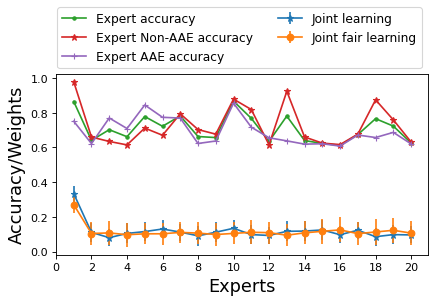

In [104]:
## plot the weights and the accuracies

figure(num=None, figsize=(6,3), dpi=80, facecolor='w', edgecolor='k')

ys = [np.mean(expertWts[i]) for i in range(len(experts))]
err = [np.std(expertWts[i]) for i in range(len(experts))]

ys2 = [np.mean(expertWtsFair[i]) for i in range(len(experts))]
err2 = [np.std(expertWtsFair[i]) for i in range(len(experts))]

ys3 = [(e.p[0] + e.p[1])/2 for e in experts]

xs = list(range(1, len(experts)+1))
plt.errorbar(xs, ys, err, fmt = "o-", label = "Joint learning", marker="*")
plt.errorbar(xs, ys2, err2, fmt = "o-", label = "Joint fair learning", marker="o")
plt.plot(xs, ys3, "o-", label = "Expert accuracy", marker=".")
plt.plot(xs, ys4, "o-", label = "Expert Non-AAE accuracy", marker="*")
plt.plot(xs, ys5, "o-", label = "Expert AAE accuracy", marker="+")
plt.xticks(np.linspace(0, 20, 11))
plt.xlabel("Experts", fontsize=16)
plt.ylabel("Accuracy/Weights", fontsize=16)
plt.legend(bbox_to_anchor=(1, 1.4), ncol=2, fontsize=11)